In [25]:
%cd /content/drive/MyDrive/Nutrition_prediction

/content/drive/MyDrive/Nutrition_prediction


In [26]:
# Colab-friendly: installs (uncomment if needed)
# !pip install -q openpyxl scikit-learn tensorflow matplotlib

# Imports
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt


In [27]:

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ========== USER SETTINGS ==========
# Path to your xlsx file (in Colab you can upload or mount Drive)
XLSX_PATH = "Nutrition Ai Dataset.xlsx"   # change to your path or upload file
SHEET_NAME = 0                     # or sheet name
TEST_SIZE = 0.15
VAL_SIZE = 0.15                     # portion of the TRAIN set used as validation during splitting (or you can use validation_split in fit)
BATCH_SIZE = 32
EPOCHS = 200
MODEL_SAVE_PATH = "multi_output_model"
# ===================================

In [28]:

# 1) Load data
df = pd.read_excel(XLSX_PATH, sheet_name=SHEET_NAME)  # requires openpyxl

# Quick preview
print("Loaded shape:", df.shape)
print(df.columns.tolist())
display(df.head())

# 2) Normalize column names (helpful if cases vary) and select columns
cols = [c.strip() for c in df.columns]
df.columns = cols

# Expected input and outputs (case-insensitive matching)
input_cols = [c for c in df.columns if c.lower() in [f"f{i}" for i in range(1,9)] + ["nir"]]
target_cols = [c for c in df.columns if c.lower() in ["proteins", "carbohydrates", "fats", "calories"]]

print("Detected input columns:", input_cols)
print("Detected target columns:", target_cols)

if len(input_cols) < 1 or len(target_cols) < 1:
    raise ValueError("Could not detect required input/target columns automatically. "
                     "Make sure your xlsx has columns F1..F8 and NIR and targets Proteins, Carbohydrates, Fats, Calories.")


Loaded shape: (110, 15)
['Name', 'Weight', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'NIR', 'Proteins', 'Carbohydrates', 'Fats', 'Calories']


,Name,Weight,F1,F2,F3,F4,F5,F6,F7,F8,NIR,Proteins,Carbohydrates,Fats,Calories
0,Tata Coffee Grand Classic,8.56,2.0,7.0,8.0,10.0,21.0,28.0,29.0,20.0,6.0,0.0,0.8,0.0,3.6
1,NaN,NaN,2.0,8.0,9.0,11.0,23.0,28.0,30.0,19.0,4.0,0.0,0.8,0.0,3.6
2,NaN,NaN,1.0,7.0,8.0,9.0,20.0,26.0,28.0,19.0,6.0,0.0,0.8,0.0,3.6
3,NaN,NaN,1.0,7.0,8.0,9.0,19.0,26.0,27.0,18.0,6.0,0.0,0.8,0.0,3.6
4,NaN,NaN,1.0,7.0,7.0,9.0,19.0,26.0,27.0,18.0,6.0,0.0,0.8,0.0,3.6


Detected input columns: ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'NIR']
Detected target columns: ['Proteins', 'Carbohydrates', 'Fats', 'Calories']


In [29]:


# Optionally drop non-numeric or extra columns
df_model = df[input_cols + target_cols].copy()

# 3) Basic cleaning: drop rows missing targets, impute inputs
before = len(df_model)
df_model = df_model.dropna(subset=target_cols)  # must have target values
after = len(df_model)
print(f"Dropped {before-after} rows missing target values. Remaining rows: {after}")

# Separate X and y
X = df_model[input_cols].values
y = df_model[target_cols].values

# Impute missing inputs (mean) and scale
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

Dropped 9 rows missing target values. Remaining rows: 101


In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 4) Train/val/test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=SEED
)

# Option A: use validation_split in model.fit
# Option B: explicit split
val_relative = VAL_SIZE / (1 - TEST_SIZE)  # to get relative val size from remaining
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_relative, random_state=SEED
)

print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])



Train/Val/Test sizes: 69 16 16


In [32]:
# 5) Build a Keras multi-output regression model
n_inputs = X_train.shape[1]
n_outputs = y_train.shape[1]

def build_regressor(input_dim, output_dim, hidden_units=[128, 64, 32], dropout=0.1):
    inp = layers.Input(shape=(input_dim,))
    x = inp
    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        if dropout and dropout > 0:
            x = layers.Dropout(dropout)(x)
    out = layers.Dense(output_dim, activation="linear")(x)  # multi-output linear
    model = models.Model(inputs=inp, outputs=out)
    return model

model = build_regressor(n_inputs, n_outputs, hidden_units=[128,64,32], dropout=0.15)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss="mse", metrics=["mae"])
model.summary()

# Callbacks: early stopping and model checkpoint
es = callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
ckpt_path = MODEL_SAVE_PATH + "/best_model.h5"
mc = callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)

# 6) Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, mc],
    verbose=2
)



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,644 (49.39 KB)

 Trainable params: 12,196 (47.64 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/200


3/3 - 5s - 2s/step - loss: 4.7101 - mae: 1.6362 - val_loss: 2.9394 - val_mae: 1.0338
Epoch 2/200


3/3 - 0s - 78ms/step - loss: 4.6692 - mae: 1.6142 - val_loss: 2.9112 - val_mae: 1.0292
Epoch 3/200


3/3 - 0s - 79ms/step - loss: 4.5913 - mae: 1.5926 - val_loss: 2.8650 - val_mae: 1.0205
Epoch 4/200


3/3 - 0s - 79ms/step - loss: 3.8323 - mae: 1.4781 - val_loss: 2.8317 - val_mae: 1.0180
Epoch 5/200


3/3 - 0s - 92ms/step - loss: 3.7956 - mae: 1.4132 - val_loss: 2.8075 - val_mae: 1.0161
Epoch 6/200


3/3 - 0s - 79ms/step - loss: 3.7230 - mae: 1.4282 - val_loss: 2.7779 - val_mae: 1.0117
Epoch 7/200


3/3 - 0s - 57ms/step - loss: 3.6734 - mae: 1.3896 - val_loss: 2.7471 - val_mae: 1.0046
Epoch 8/200


3/3 - 0s - 54ms/step - loss: 3.7177 - mae: 1.3849 - val_loss: 2.7187 - val_mae: 0.9990
Epoch 9/200


3/3 - 0s - 57ms/step - loss: 3.6253 - mae: 1.3909 - val_loss: 2.6887 - val_mae: 0.9926
Epoch 10/200


3/3 - 0s - 64ms/step - loss: 3.6358 - mae: 1.3710 - val_loss: 2.6676 - val_mae: 0.9877
Epoch 11/200


3/3 - 0s - 90ms/step - loss: 3.5729 - mae: 1.3725 - val_loss: 2.6376 - val_mae: 0.9820
Epoch 12/200


3/3 - 0s - 55ms/step - loss: 3.5123 - mae: 1.3351 - val_loss: 2.6115 - val_mae: 0.9753
Epoch 13/200


3/3 - 0s - 100ms/step - loss: 3.2024 - mae: 1.2880 - val_loss: 2.5691 - val_mae: 0.9661
Epoch 14/200


3/3 - 0s - 56ms/step - loss: 3.3341 - mae: 1.3213 - val_loss: 2.5361 - val_mae: 0.9601
Epoch 15/200


3/3 - 0s - 70ms/step - loss: 3.2961 - mae: 1.2640 - val_loss: 2.4886 - val_mae: 0.9496
Epoch 16/200


3/3 - 0s - 57ms/step - loss: 3.2102 - mae: 1.2726 - val_loss: 2.4458 - val_mae: 0.9415
Epoch 17/200


3/3 - 0s - 56ms/step - loss: 3.1205 - mae: 1.2627 - val_loss: 2.4092 - val_mae: 0.9328
Epoch 18/200


3/3 - 0s - 54ms/step - loss: 3.1885 - mae: 1.2936 - val_loss: 2.3715 - val_mae: 0.9250
Epoch 19/200


3/3 - 0s - 55ms/step - loss: 3.2543 - mae: 1.3299 - val_loss: 2.3378 - val_mae: 0.9192
Epoch 20/200


3/3 - 0s - 57ms/step - loss: 3.0855 - mae: 1.2624 - val_loss: 2.3051 - val_mae: 0.9114
Epoch 21/200


3/3 - 0s - 63ms/step - loss: 3.0137 - mae: 1.2200 - val_loss: 2.2688 - val_mae: 0.9031
Epoch 22/200


3/3 - 0s - 59ms/step - loss: 2.8281 - mae: 1.1869 - val_loss: 2.2249 - val_mae: 0.8947
Epoch 23/200


3/3 - 0s - 63ms/step - loss: 2.9108 - mae: 1.2012 - val_loss: 2.1781 - val_mae: 0.8887
Epoch 24/200


3/3 - 0s - 58ms/step - loss: 3.0024 - mae: 1.2308 - val_loss: 2.1340 - val_mae: 0.8809
Epoch 25/200


3/3 - 0s - 57ms/step - loss: 3.0034 - mae: 1.2023 - val_loss: 2.0893 - val_mae: 0.8727
Epoch 26/200


3/3 - 0s - 65ms/step - loss: 2.6466 - mae: 1.1392 - val_loss: 2.0475 - val_mae: 0.8641
Epoch 27/200


3/3 - 0s - 57ms/step - loss: 2.5980 - mae: 1.1626 - val_loss: 2.0112 - val_mae: 0.8558
Epoch 28/200


3/3 - 0s - 57ms/step - loss: 2.5846 - mae: 1.1463 - val_loss: 1.9850 - val_mae: 0.8505
Epoch 29/200


3/3 - 0s - 56ms/step - loss: 2.3761 - mae: 1.0861 - val_loss: 1.9611 - val_mae: 0.8425
Epoch 30/200


3/3 - 0s - 59ms/step - loss: 2.4520 - mae: 1.1097 - val_loss: 1.9366 - val_mae: 0.8336
Epoch 31/200


3/3 - 0s - 59ms/step - loss: 2.3507 - mae: 1.0919 - val_loss: 1.9074 - val_mae: 0.8257
Epoch 32/200


3/3 - 0s - 75ms/step - loss: 2.4923 - mae: 1.1220 - val_loss: 1.8720 - val_mae: 0.8189
Epoch 33/200


3/3 - 0s - 57ms/step - loss: 2.3638 - mae: 1.0850 - val_loss: 1.8331 - val_mae: 0.8095
Epoch 34/200


3/3 - 0s - 57ms/step - loss: 2.5436 - mae: 1.1627 - val_loss: 1.8023 - val_mae: 0.8013
Epoch 35/200


3/3 - 0s - 64ms/step - loss: 2.4775 - mae: 1.0939 - val_loss: 1.7703 - val_mae: 0.7952
Epoch 36/200


3/3 - 0s - 57ms/step - loss: 2.3241 - mae: 1.0866 - val_loss: 1.7404 - val_mae: 0.7895
Epoch 37/200


3/3 - 0s - 63ms/step - loss: 2.3193 - mae: 1.1024 - val_loss: 1.7135 - val_mae: 0.7845
Epoch 38/200


3/3 - 0s - 59ms/step - loss: 2.2463 - mae: 1.0731 - val_loss: 1.6843 - val_mae: 0.7785
Epoch 39/200


3/3 - 0s - 59ms/step - loss: 2.1988 - mae: 1.0394 - val_loss: 1.6545 - val_mae: 0.7714
Epoch 40/200


3/3 - 0s - 59ms/step - loss: 2.1492 - mae: 1.0167 - val_loss: 1.6274 - val_mae: 0.7641
Epoch 41/200


3/3 - 0s - 59ms/step - loss: 2.2398 - mae: 1.0346 - val_loss: 1.6040 - val_mae: 0.7578
Epoch 42/200


3/3 - 0s - 59ms/step - loss: 2.1332 - mae: 1.0333 - val_loss: 1.5707 - val_mae: 0.7505
Epoch 43/200


3/3 - 0s - 62ms/step - loss: 2.1758 - mae: 1.0244 - val_loss: 1.5365 - val_mae: 0.7432
Epoch 44/200


3/3 - 0s - 58ms/step - loss: 2.0263 - mae: 1.0197 - val_loss: 1.5175 - val_mae: 0.7394
Epoch 45/200


3/3 - 0s - 55ms/step - loss: 2.0137 - mae: 0.9977 - val_loss: 1.4901 - val_mae: 0.7323
Epoch 46/200


3/3 - 0s - 57ms/step - loss: 2.0844 - mae: 1.0084 - val_loss: 1.4613 - val_mae: 0.7244
Epoch 47/200


3/3 - 0s - 59ms/step - loss: 2.0257 - mae: 0.9624 - val_loss: 1.4318 - val_mae: 0.7168
Epoch 48/200


3/3 - 0s - 57ms/step - loss: 1.9039 - mae: 0.9984 - val_loss: 1.4047 - val_mae: 0.7122
Epoch 49/200


3/3 - 0s - 60ms/step - loss: 1.8276 - mae: 0.9637 - val_loss: 1.3681 - val_mae: 0.7037
Epoch 50/200


3/3 - 0s - 57ms/step - loss: 1.9185 - mae: 0.9704 - val_loss: 1.3305 - val_mae: 0.6947
Epoch 51/200


3/3 - 0s - 55ms/step - loss: 1.8949 - mae: 0.9639 - val_loss: 1.3055 - val_mae: 0.6866
Epoch 52/200


3/3 - 0s - 57ms/step - loss: 1.5501 - mae: 0.8700 - val_loss: 1.2836 - val_mae: 0.6801
Epoch 53/200


3/3 - 0s - 59ms/step - loss: 1.7514 - mae: 0.9443 - val_loss: 1.2670 - val_mae: 0.6758
Epoch 54/200


3/3 - 0s - 57ms/step - loss: 1.9112 - mae: 0.9584 - val_loss: 1.2666 - val_mae: 0.6776
Epoch 55/200


3/3 - 0s - 63ms/step - loss: 1.6376 - mae: 0.9186 - val_loss: 1.2545 - val_mae: 0.6753
Epoch 56/200


3/3 - 0s - 55ms/step - loss: 1.7273 - mae: 0.9296 - val_loss: 1.2433 - val_mae: 0.6737
Epoch 57/200


3/3 - 0s - 57ms/step - loss: 1.6446 - mae: 0.8991 - val_loss: 1.2332 - val_mae: 0.6701
Epoch 58/200


3/3 - 0s - 58ms/step - loss: 1.2788 - mae: 0.7941 - val_loss: 1.2151 - val_mae: 0.6654
Epoch 59/200


3/3 - 0s - 60ms/step - loss: 1.4088 - mae: 0.8683 - val_loss: 1.1936 - val_mae: 0.6617
Epoch 60/200


3/3 - 0s - 90ms/step - loss: 1.3498 - mae: 0.8108 - val_loss: 1.1678 - val_mae: 0.6555
Epoch 61/200


3/3 - 0s - 91ms/step - loss: 1.2849 - mae: 0.8265 - val_loss: 1.1329 - val_mae: 0.6448
Epoch 62/200


3/3 - 0s - 83ms/step - loss: 1.2083 - mae: 0.7911 - val_loss: 1.0884 - val_mae: 0.6324
Epoch 63/200


3/3 - 0s - 94ms/step - loss: 1.2732 - mae: 0.7946 - val_loss: 1.0419 - val_mae: 0.6174
Epoch 64/200


3/3 - 0s - 96ms/step - loss: 1.2905 - mae: 0.7919 - val_loss: 1.0019 - val_mae: 0.6058
Epoch 65/200


3/3 - 0s - 70ms/step - loss: 1.3630 - mae: 0.7942 - val_loss: 0.9700 - val_mae: 0.5975
Epoch 66/200


3/3 - 0s - 107ms/step - loss: 1.2069 - mae: 0.7892 - val_loss: 0.9369 - val_mae: 0.5892
Epoch 67/200


3/3 - 0s - 73ms/step - loss: 1.0634 - mae: 0.7277 - val_loss: 0.8983 - val_mae: 0.5785
Epoch 68/200


3/3 - 0s - 82ms/step - loss: 1.1084 - mae: 0.7734 - val_loss: 0.8643 - val_mae: 0.5679
Epoch 69/200


3/3 - 0s - 85ms/step - loss: 1.2582 - mae: 0.8024 - val_loss: 0.8363 - val_mae: 0.5585
Epoch 70/200


3/3 - 0s - 98ms/step - loss: 1.0563 - mae: 0.7508 - val_loss: 0.8103 - val_mae: 0.5499
Epoch 71/200


3/3 - 0s - 82ms/step - loss: 1.0456 - mae: 0.7083 - val_loss: 0.7825 - val_mae: 0.5415
Epoch 72/200


3/3 - 0s - 98ms/step - loss: 1.2122 - mae: 0.7575 - val_loss: 0.7595 - val_mae: 0.5339
Epoch 73/200


3/3 - 0s - 85ms/step - loss: 1.0055 - mae: 0.7166 - val_loss: 0.7346 - val_mae: 0.5242
Epoch 74/200


3/3 - 0s - 62ms/step - loss: 1.0397 - mae: 0.7203 - val_loss: 0.7022 - val_mae: 0.5114
Epoch 75/200


3/3 - 0s - 57ms/step - loss: 1.2431 - mae: 0.7782 - val_loss: 0.6772 - val_mae: 0.5016
Epoch 76/200


3/3 - 0s - 60ms/step - loss: 0.9697 - mae: 0.7130 - val_loss: 0.6583 - val_mae: 0.4944
Epoch 77/200


3/3 - 0s - 61ms/step - loss: 0.8612 - mae: 0.6542 - val_loss: 0.6450 - val_mae: 0.4900
Epoch 78/200


3/3 - 0s - 60ms/step - loss: 0.7809 - mae: 0.6266 - val_loss: 0.6277 - val_mae: 0.4850
Epoch 79/200


3/3 - 0s - 59ms/step - loss: 0.9540 - mae: 0.6878 - val_loss: 0.6070 - val_mae: 0.4789
Epoch 80/200


3/3 - 0s - 60ms/step - loss: 0.7611 - mae: 0.6329 - val_loss: 0.5836 - val_mae: 0.4710
Epoch 81/200


3/3 - 0s - 59ms/step - loss: 0.9466 - mae: 0.6990 - val_loss: 0.5563 - val_mae: 0.4609
Epoch 82/200


3/3 - 0s - 61ms/step - loss: 0.6473 - mae: 0.5830 - val_loss: 0.5294 - val_mae: 0.4504
Epoch 83/200


3/3 - 0s - 64ms/step - loss: 0.6655 - mae: 0.5811 - val_loss: 0.5092 - val_mae: 0.4424
Epoch 84/200


3/3 - 0s - 65ms/step - loss: 0.8387 - mae: 0.6147 - val_loss: 0.4845 - val_mae: 0.4322
Epoch 85/200


3/3 - 0s - 62ms/step - loss: 0.7184 - mae: 0.5980 - val_loss: 0.4661 - val_mae: 0.4237
Epoch 86/200


3/3 - 0s - 61ms/step - loss: 0.6053 - mae: 0.5508 - val_loss: 0.4540 - val_mae: 0.4186
Epoch 87/200


3/3 - 0s - 61ms/step - loss: 0.7291 - mae: 0.6180 - val_loss: 0.4385 - val_mae: 0.4112
Epoch 88/200


3/3 - 0s - 63ms/step - loss: 0.5177 - mae: 0.5052 - val_loss: 0.4257 - val_mae: 0.4051
Epoch 89/200


3/3 - 0s - 67ms/step - loss: 0.6595 - mae: 0.5791 - val_loss: 0.4167 - val_mae: 0.4008
Epoch 90/200


3/3 - 0s - 66ms/step - loss: 0.6006 - mae: 0.5317 - val_loss: 0.4052 - val_mae: 0.3949
Epoch 91/200


3/3 - 0s - 65ms/step - loss: 0.6051 - mae: 0.5615 - val_loss: 0.3893 - val_mae: 0.3876
Epoch 92/200


3/3 - 0s - 63ms/step - loss: 0.6255 - mae: 0.5734 - val_loss: 0.3746 - val_mae: 0.3810
Epoch 93/200


3/3 - 0s - 76ms/step - loss: 0.5397 - mae: 0.5223 - val_loss: 0.3583 - val_mae: 0.3730
Epoch 94/200


3/3 - 0s - 63ms/step - loss: 0.5621 - mae: 0.4916 - val_loss: 0.3357 - val_mae: 0.3612
Epoch 95/200


3/3 - 0s - 61ms/step - loss: 0.4772 - mae: 0.4873 - val_loss: 0.3146 - val_mae: 0.3507
Epoch 96/200


3/3 - 0s - 65ms/step - loss: 0.5367 - mae: 0.5320 - val_loss: 0.2944 - val_mae: 0.3406
Epoch 97/200


3/3 - 0s - 58ms/step - loss: 0.5462 - mae: 0.5210 - val_loss: 0.2751 - val_mae: 0.3302
Epoch 98/200


3/3 - 0s - 64ms/step - loss: 0.5891 - mae: 0.5504 - val_loss: 0.2584 - val_mae: 0.3212
Epoch 99/200


3/3 - 0s - 101ms/step - loss: 0.5205 - mae: 0.5038 - val_loss: 0.2483 - val_mae: 0.3156
Epoch 100/200


3/3 - 0s - 65ms/step - loss: 0.3870 - mae: 0.4502 - val_loss: 0.2397 - val_mae: 0.3116
Epoch 101/200


3/3 - 0s - 63ms/step - loss: 0.5229 - mae: 0.5172 - val_loss: 0.2323 - val_mae: 0.3081
Epoch 102/200


3/3 - 0s - 62ms/step - loss: 0.4447 - mae: 0.4534 - val_loss: 0.2277 - val_mae: 0.3045
Epoch 103/200


3/3 - 0s - 81ms/step - loss: 0.4033 - mae: 0.4685 - val_loss: 0.2237 - val_mae: 0.3010
Epoch 104/200


3/3 - 0s - 97ms/step - loss: 0.4331 - mae: 0.4645 - val_loss: 0.2128 - val_mae: 0.2923
Epoch 105/200


3/3 - 0s - 72ms/step - loss: 0.4601 - mae: 0.4857 - val_loss: 0.1995 - val_mae: 0.2812
Epoch 106/200


3/3 - 0s - 113ms/step - loss: 0.4232 - mae: 0.4498 - val_loss: 0.1868 - val_mae: 0.2703
Epoch 107/200


3/3 - 0s - 98ms/step - loss: 0.4698 - mae: 0.4692 - val_loss: 0.1760 - val_mae: 0.2622
Epoch 108/200


3/3 - 0s - 74ms/step - loss: 0.4427 - mae: 0.4513 - val_loss: 0.1651 - val_mae: 0.2529
Epoch 109/200


3/3 - 0s - 96ms/step - loss: 0.4704 - mae: 0.4806 - val_loss: 0.1570 - val_mae: 0.2461
Epoch 110/200


3/3 - 0s - 83ms/step - loss: 0.3894 - mae: 0.4442 - val_loss: 0.1526 - val_mae: 0.2432
Epoch 111/200


3/3 - 0s - 107ms/step - loss: 0.4695 - mae: 0.4736 - val_loss: 0.1458 - val_mae: 0.2379
Epoch 112/200


3/3 - 0s - 96ms/step - loss: 0.4159 - mae: 0.4322 - val_loss: 0.1401 - val_mae: 0.2337
Epoch 113/200


3/3 - 0s - 90ms/step - loss: 0.3210 - mae: 0.4146 - val_loss: 0.1349 - val_mae: 0.2301
Epoch 114/200


3/3 - 0s - 96ms/step - loss: 0.2882 - mae: 0.3828 - val_loss: 0.1307 - val_mae: 0.2275
Epoch 115/200


3/3 - 0s - 93ms/step - loss: 0.4457 - mae: 0.4663 - val_loss: 0.1266 - val_mae: 0.2247
Epoch 116/200


3/3 - 0s - 106ms/step - loss: 0.3831 - mae: 0.4277 - val_loss: 0.1220 - val_mae: 0.2215
Epoch 117/200


3/3 - 0s - 64ms/step - loss: 0.3720 - mae: 0.4298 - val_loss: 0.1165 - val_mae: 0.2168
Epoch 118/200


3/3 - 0s - 87ms/step - loss: 0.4952 - mae: 0.4669 - val_loss: 0.1109 - val_mae: 0.2105
Epoch 119/200


3/3 - 0s - 94ms/step - loss: 0.2914 - mae: 0.3892 - val_loss: 0.1046 - val_mae: 0.2032
Epoch 120/200


3/3 - 0s - 77ms/step - loss: 0.2963 - mae: 0.3946 - val_loss: 0.0984 - val_mae: 0.1954
Epoch 121/200


3/3 - 0s - 82ms/step - loss: 0.3486 - mae: 0.4297 - val_loss: 0.0922 - val_mae: 0.1866
Epoch 122/200


3/3 - 0s - 82ms/step - loss: 0.3006 - mae: 0.3845 - val_loss: 0.0862 - val_mae: 0.1788
Epoch 123/200


3/3 - 0s - 70ms/step - loss: 0.3451 - mae: 0.4116 - val_loss: 0.0822 - val_mae: 0.1738
Epoch 124/200


3/3 - 0s - 73ms/step - loss: 0.3355 - mae: 0.4127 - val_loss: 0.0780 - val_mae: 0.1688
Epoch 125/200


3/3 - 0s - 97ms/step - loss: 0.3956 - mae: 0.4252 - val_loss: 0.0752 - val_mae: 0.1666
Epoch 126/200


3/3 - 0s - 87ms/step - loss: 0.2452 - mae: 0.3568 - val_loss: 0.0718 - val_mae: 0.1630
Epoch 127/200


3/3 - 0s - 93ms/step - loss: 0.3120 - mae: 0.3911 - val_loss: 0.0694 - val_mae: 0.1606
Epoch 128/200


3/3 - 0s - 90ms/step - loss: 0.3535 - mae: 0.4043 - val_loss: 0.0669 - val_mae: 0.1587
Epoch 129/200


3/3 - 0s - 94ms/step - loss: 0.3478 - mae: 0.4074 - val_loss: 0.0652 - val_mae: 0.1582
Epoch 130/200


3/3 - 0s - 87ms/step - loss: 0.2859 - mae: 0.3831 - val_loss: 0.0644 - val_mae: 0.1584
Epoch 131/200


3/3 - 0s - 96ms/step - loss: 0.3403 - mae: 0.3973 - val_loss: 0.0622 - val_mae: 0.1573
Epoch 132/200


3/3 - 0s - 65ms/step - loss: 0.3609 - mae: 0.3750 - val_loss: 0.0607 - val_mae: 0.1561
Epoch 133/200


3/3 - 0s - 65ms/step - loss: 0.3784 - mae: 0.3976 - val_loss: 0.0598 - val_mae: 0.1555
Epoch 134/200
3/3 - 0s - 34ms/step - loss: 0.4125 - mae: 0.4014 - val_loss: 0.0599 - val_mae: 0.1561
Epoch 135/200
3/3 - 0s - 34ms/step - loss: 0.3011 - mae: 0.3854 - val_loss: 0.0603 - val_mae: 0.1568
Epoch 136/200


3/3 - 0s - 64ms/step - loss: 0.2526 - mae: 0.3679 - val_loss: 0.0597 - val_mae: 0.1562
Epoch 137/200


3/3 - 0s - 56ms/step - loss: 0.2978 - mae: 0.3857 - val_loss: 0.0593 - val_mae: 0.1558
Epoch 138/200
3/3 - 0s - 31ms/step - loss: 0.3123 - mae: 0.3900 - val_loss: 0.0598 - val_mae: 0.1560
Epoch 139/200
3/3 - 0s - 31ms/step - loss: 0.2594 - mae: 0.3674 - val_loss: 0.0599 - val_mae: 0.1551
Epoch 140/200


3/3 - 0s - 55ms/step - loss: 0.3374 - mae: 0.3957 - val_loss: 0.0591 - val_mae: 0.1532
Epoch 141/200
3/3 - 0s - 33ms/step - loss: 0.3155 - mae: 0.3794 - val_loss: 0.0612 - val_mae: 0.1547
Epoch 142/200
3/3 - 0s - 33ms/step - loss: 0.2519 - mae: 0.3410 - val_loss: 0.0637 - val_mae: 0.1581
Epoch 143/200
3/3 - 0s - 30ms/step - loss: 0.2864 - mae: 0.3760 - val_loss: 0.0639 - val_mae: 0.1591
Epoch 144/200
3/3 - 0s - 31ms/step - loss: 0.2459 - mae: 0.3299 - val_loss: 0.0623 - val_mae: 0.1578
Epoch 145/200
3/3 - 0s - 35ms/step - loss: 0.2564 - mae: 0.3553 - val_loss: 0.0617 - val_mae: 0.1570
Epoch 146/200
3/3 - 0s - 33ms/step - loss: 0.3505 - mae: 0.3874 - val_loss: 0.0604 - val_mae: 0.1557
Epoch 147/200


3/3 - 0s - 57ms/step - loss: 0.3208 - mae: 0.3884 - val_loss: 0.0581 - val_mae: 0.1530
Epoch 148/200


3/3 - 0s - 56ms/step - loss: 0.2555 - mae: 0.3530 - val_loss: 0.0549 - val_mae: 0.1491
Epoch 149/200


3/3 - 0s - 58ms/step - loss: 0.2442 - mae: 0.3438 - val_loss: 0.0515 - val_mae: 0.1452
Epoch 150/200


3/3 - 0s - 61ms/step - loss: 0.2163 - mae: 0.3363 - val_loss: 0.0479 - val_mae: 0.1416
Epoch 151/200


3/3 - 0s - 63ms/step - loss: 0.2308 - mae: 0.3381 - val_loss: 0.0449 - val_mae: 0.1388
Epoch 152/200


3/3 - 0s - 59ms/step - loss: 0.2790 - mae: 0.3854 - val_loss: 0.0428 - val_mae: 0.1365
Epoch 153/200


3/3 - 0s - 55ms/step - loss: 0.2610 - mae: 0.3305 - val_loss: 0.0409 - val_mae: 0.1337
Epoch 154/200


3/3 - 0s - 56ms/step - loss: 0.3353 - mae: 0.3912 - val_loss: 0.0401 - val_mae: 0.1326
Epoch 155/200


3/3 - 0s - 60ms/step - loss: 0.3096 - mae: 0.3823 - val_loss: 0.0390 - val_mae: 0.1310
Epoch 156/200


3/3 - 0s - 60ms/step - loss: 0.2840 - mae: 0.3741 - val_loss: 0.0381 - val_mae: 0.1288
Epoch 157/200


3/3 - 0s - 72ms/step - loss: 0.3128 - mae: 0.3489 - val_loss: 0.0372 - val_mae: 0.1266
Epoch 158/200


3/3 - 0s - 56ms/step - loss: 0.2451 - mae: 0.3489 - val_loss: 0.0368 - val_mae: 0.1253
Epoch 159/200


3/3 - 0s - 55ms/step - loss: 0.2463 - mae: 0.3584 - val_loss: 0.0359 - val_mae: 0.1240
Epoch 160/200


3/3 - 0s - 62ms/step - loss: 0.2383 - mae: 0.3427 - val_loss: 0.0350 - val_mae: 0.1227
Epoch 161/200


3/3 - 0s - 58ms/step - loss: 0.2891 - mae: 0.3529 - val_loss: 0.0344 - val_mae: 0.1219
Epoch 162/200


3/3 - 0s - 61ms/step - loss: 0.2060 - mae: 0.3330 - val_loss: 0.0326 - val_mae: 0.1194
Epoch 163/200


3/3 - 0s - 57ms/step - loss: 0.3382 - mae: 0.3769 - val_loss: 0.0310 - val_mae: 0.1173
Epoch 164/200


3/3 - 0s - 58ms/step - loss: 0.2893 - mae: 0.3604 - val_loss: 0.0296 - val_mae: 0.1156
Epoch 165/200


3/3 - 0s - 59ms/step - loss: 0.3336 - mae: 0.3865 - val_loss: 0.0280 - val_mae: 0.1137
Epoch 166/200


3/3 - 0s - 62ms/step - loss: 0.2427 - mae: 0.3398 - val_loss: 0.0266 - val_mae: 0.1108
Epoch 167/200


3/3 - 0s - 56ms/step - loss: 0.3361 - mae: 0.3357 - val_loss: 0.0256 - val_mae: 0.1088
Epoch 168/200


3/3 - 0s - 64ms/step - loss: 0.2730 - mae: 0.3531 - val_loss: 0.0251 - val_mae: 0.1081
Epoch 169/200


3/3 - 0s - 57ms/step - loss: 0.2952 - mae: 0.3709 - val_loss: 0.0250 - val_mae: 0.1083
Epoch 170/200
3/3 - 0s - 32ms/step - loss: 0.2492 - mae: 0.3468 - val_loss: 0.0255 - val_mae: 0.1090
Epoch 171/200
3/3 - 0s - 31ms/step - loss: 0.2606 - mae: 0.3624 - val_loss: 0.0262 - val_mae: 0.1098
Epoch 172/200
3/3 - 0s - 32ms/step - loss: 0.1640 - mae: 0.2855 - val_loss: 0.0263 - val_mae: 0.1098
Epoch 173/200
3/3 - 0s - 32ms/step - loss: 0.2522 - mae: 0.3524 - val_loss: 0.0261 - val_mae: 0.1091
Epoch 174/200
3/3 - 0s - 31ms/step - loss: 0.2782 - mae: 0.3472 - val_loss: 0.0251 - val_mae: 0.1068
Epoch 175/200


3/3 - 0s - 56ms/step - loss: 0.2371 - mae: 0.3228 - val_loss: 0.0243 - val_mae: 0.1042
Epoch 176/200


3/3 - 0s - 60ms/step - loss: 0.2354 - mae: 0.3271 - val_loss: 0.0231 - val_mae: 0.1010
Epoch 177/200


3/3 - 0s - 56ms/step - loss: 0.2764 - mae: 0.3515 - val_loss: 0.0220 - val_mae: 0.0980
Epoch 178/200


3/3 - 0s - 57ms/step - loss: 0.2275 - mae: 0.3371 - val_loss: 0.0213 - val_mae: 0.0966
Epoch 179/200


3/3 - 0s - 59ms/step - loss: 0.3753 - mae: 0.3853 - val_loss: 0.0211 - val_mae: 0.0954
Epoch 180/200


3/3 - 0s - 57ms/step - loss: 0.2631 - mae: 0.3404 - val_loss: 0.0210 - val_mae: 0.0943
Epoch 181/200
3/3 - 0s - 31ms/step - loss: 0.2416 - mae: 0.3307 - val_loss: 0.0219 - val_mae: 0.0953
Epoch 182/200
3/3 - 0s - 31ms/step - loss: 0.2943 - mae: 0.3481 - val_loss: 0.0222 - val_mae: 0.0954
Epoch 183/200
3/3 - 0s - 46ms/step - loss: 0.2217 - mae: 0.3273 - val_loss: 0.0215 - val_mae: 0.0935
Epoch 184/200
3/3 - 0s - 32ms/step - loss: 0.1805 - mae: 0.3141 - val_loss: 0.0211 - val_mae: 0.0944
Epoch 185/200
3/3 - 0s - 32ms/step - loss: 0.2309 - mae: 0.3305 - val_loss: 0.0211 - val_mae: 0.0967
Epoch 186/200
3/3 - 0s - 31ms/step - loss: 0.2201 - mae: 0.3157 - val_loss: 0.0210 - val_mae: 0.0987
Epoch 187/200


3/3 - 0s - 60ms/step - loss: 0.3065 - mae: 0.3530 - val_loss: 0.0204 - val_mae: 0.0992
Epoch 188/200


3/3 - 0s - 57ms/step - loss: 0.1990 - mae: 0.3021 - val_loss: 0.0197 - val_mae: 0.1003
Epoch 189/200


3/3 - 0s - 56ms/step - loss: 0.1912 - mae: 0.3049 - val_loss: 0.0189 - val_mae: 0.0996
Epoch 190/200


3/3 - 0s - 64ms/step - loss: 0.2267 - mae: 0.3415 - val_loss: 0.0180 - val_mae: 0.0975
Epoch 191/200


3/3 - 0s - 62ms/step - loss: 0.1693 - mae: 0.2932 - val_loss: 0.0175 - val_mae: 0.0960
Epoch 192/200


3/3 - 0s - 59ms/step - loss: 0.1882 - mae: 0.3246 - val_loss: 0.0165 - val_mae: 0.0941
Epoch 193/200


3/3 - 0s - 59ms/step - loss: 0.2199 - mae: 0.3246 - val_loss: 0.0158 - val_mae: 0.0915
Epoch 194/200


3/3 - 0s - 58ms/step - loss: 0.2249 - mae: 0.3294 - val_loss: 0.0150 - val_mae: 0.0895
Epoch 195/200


3/3 - 0s - 57ms/step - loss: 0.2781 - mae: 0.3641 - val_loss: 0.0147 - val_mae: 0.0893
Epoch 196/200
3/3 - 0s - 59ms/step - loss: 0.1898 - mae: 0.2908 - val_loss: 0.0156 - val_mae: 0.0901
Epoch 197/200
3/3 - 0s - 96ms/step - loss: 0.3048 - mae: 0.3580 - val_loss: 0.0171 - val_mae: 0.0923
Epoch 198/200
3/3 - 0s - 43ms/step - loss: 0.2119 - mae: 0.3049 - val_loss: 0.0177 - val_mae: 0.0934
Epoch 199/200
3/3 - 0s - 43ms/step - loss: 0.2350 - mae: 0.3309 - val_loss: 0.0179 - val_mae: 0.0939
Epoch 200/200
3/3 - 0s - 58ms/step - loss: 0.2241 - mae: 0.3351 - val_loss: 0.0177 - val_mae: 0.0929


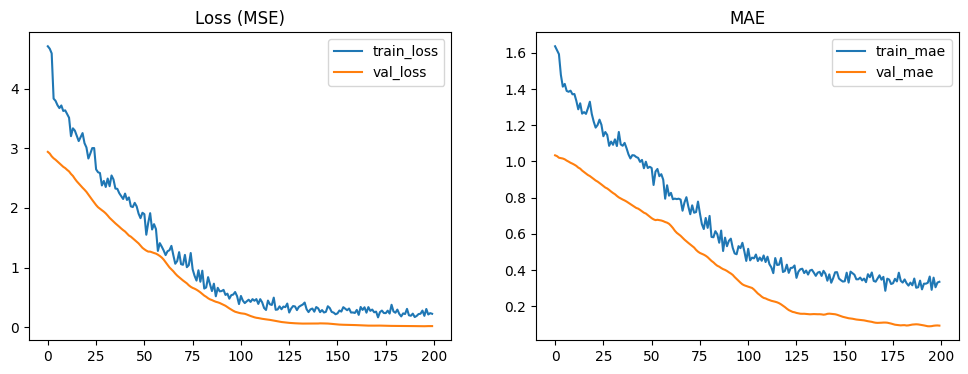

In [34]:
# 7) Plot training history
def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    axes[0].plot(history.history['loss'], label='train_loss')
    axes[0].plot(history.history['val_loss'], label='val_loss')
    axes[0].set_title('Loss (MSE)')
    axes[0].legend()
    axes[1].plot(history.history['mae'], label='train_mae')
    axes[1].plot(history.history['val_mae'], label='val_mae')
    axes[1].set_title('MAE')
    axes[1].legend()
    plt.show()

plot_history(history)

In [35]:
# 8) Evaluate on test set (NN)
y_pred_test = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print(f"NN Test MSE (all targets combined): {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
NN Test MSE (all targets combined): 0.0197, MAE: 0.0890, R2: 0.5343


In [36]:
# Per-target metrics
for i, name in enumerate(target_cols):
    mse_i = mean_squared_error(y_test[:, i], y_pred_test[:, i])
    mae_i = mean_absolute_error(y_test[:, i], y_pred_test[:, i])
    r2_i = r2_score(y_test[:, i], y_pred_test[:, i])
    print(f"Target: {name:12s}  MSE: {mse_i:.4f}  MAE: {mae_i:.4f}  R2: {r2_i:.4f}")


Target: Proteins      MSE: 0.0018  MAE: 0.0356  R2: 0.6110
Target: Carbohydrates  MSE: 0.0046  MAE: 0.0516  R2: 0.7830
Target: Fats          MSE: 0.0057  MAE: 0.0661  R2: 0.1137
Target: Calories      MSE: 0.0668  MAE: 0.2026  R2: 0.6296


In [37]:
# 9) Baseline: RandomForest (multi-output using MultiOutputRegressor)
print("\nTraining a RandomForest multi-output baseline (this may take time on large datasets)...")
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=SEED, n_jobs=-1))
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RF Test MSE: {mse_rf:.4f}, MAE: {mae_rf:.4f}, R2: {r2_rf:.4f}")



Training a RandomForest multi-output baseline (this may take time on large datasets)...
RF Test MSE: 0.0135, MAE: 0.0515, R2: 0.8487


In [38]:
for i, name in enumerate(target_cols):
    mse_i = mean_squared_error(y_test[:, i], y_pred_rf[:, i])
    mae_i = mean_absolute_error(y_test[:, i], y_pred_rf[:, i])
    r2_i = r2_score(y_test[:, i], y_pred_rf[:, i])
    print(f"RF Target: {name:12s}  MSE: {mse_i:.4f}  MAE: {mae_i:.4f}  R2: {r2_i:.4f}")


RF Target: Proteins      MSE: 0.0007  MAE: 0.0164  R2: 0.8447
RF Target: Carbohydrates  MSE: 0.0018  MAE: 0.0253  R2: 0.9153
RF Target: Fats          MSE: 0.0005  MAE: 0.0140  R2: 0.9182
RF Target: Calories      MSE: 0.0511  MAE: 0.1502  R2: 0.7168


In [39]:
# 10) Save scaler & imputer (so you can preprocess new samples the same way)
import joblib
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
joblib.dump(imputer, os.path.join(MODEL_SAVE_PATH, "imputer.joblib"))
joblib.dump(scaler, os.path.join(MODEL_SAVE_PATH, "scaler.joblib"))
# Save target column order too
joblib.dump(target_cols, os.path.join(MODEL_SAVE_PATH, "target_cols.joblib"))
joblib.dump(input_cols, os.path.join(MODEL_SAVE_PATH, "input_cols.joblib"))
print("Preprocessing artifacts saved.")

Preprocessing artifacts saved.


In [40]:
# 11) Example: predict for a new sample (raw values)
def predict_sample(raw_sample_dict):
    """
    raw_sample_dict: dict {colname: value} with keys matching input_cols (F1..F8 and NIR)
    returns: pandas Series with predicted targets
    """
    # load artifacts
    imputer = joblib.load(os.path.join(MODEL_SAVE_PATH, "imputer.joblib"))
    scaler = joblib.load(os.path.join(MODEL_SAVE_PATH, "scaler.joblib"))
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    # build array in correct order
    x_arr = np.array([[ raw_sample_dict.get(c, np.nan) for c in input_cols ]], dtype=float)
    x_arr = imputer.transform(x_arr)
    x_arr = scaler.transform(x_arr)
    ypred = model.predict(x_arr)
    return pd.Series(ypred.flatten(), index=target_cols)

In [42]:
# Save as Keras v3 file
MODEL_SAVE_PATH = "multi_output_model_1"   # keep for artifacts
keras_path = MODEL_SAVE_PATH + ".keras"
model.save(keras_path, include_optimizer=False)
print("Saved model to:", keras_path)


Saved model to: multi_output_model_1.keras


In [43]:
import tensorflow as tf
model = tf.keras.models.load_model("multi_output_model_1.keras")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [47]:
import tensorflow as tf
import numpy as np
import pandas as pd
import joblib

# === 1. Load model and preprocessing artifacts ===
MODEL_DIR = "multi_output_model"   # folder where preprocessing artifacts are stored
MODEL_FILE = "multi_output_model_1.keras"   # your trained Keras model file

# Load the trained model (no optimizer needed for inference)
model = tf.keras.models.load_model(MODEL_FILE, compile=False)

# Load preprocessing tools and metadata
imputer = joblib.load(f"{MODEL_DIR}/imputer.joblib")
scaler = joblib.load(f"{MODEL_DIR}/scaler.joblib")
input_cols = joblib.load(f"{MODEL_DIR}/input_cols.joblib")
target_cols = joblib.load(f"{MODEL_DIR}/target_cols.joblib")

In [48]:
print("Model and preprocessing loaded successfully ✅")
print("Input features:", input_cols)
print("Target outputs:", target_cols)

Model and preprocessing loaded successfully ✅
Input features: ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'NIR']
Target outputs: ['Proteins', 'Carbohydrates', 'Fats', 'Calories']


In [50]:
# === Define your test sample ===
sample = {
    "F1": 7,
    "F2": 40,
    "F3": 46,
    "F4": 53,
    "F5": 90,
    "F6": 94,
    "F7": 78,
    "F8": 49,
    "NIR": 14
}

In [51]:
# === 3. Prepare input for model ===
# Arrange inputs in the same order as during training
x_arr = np.array([[sample.get(c, np.nan) for c in input_cols]], dtype=float)

# Handle missing values and scaling (same pipeline as training)
x_arr = imputer.transform(x_arr)
x_arr = scaler.transform(x_arr)

# === 4. Predict ===
y_pred = model.predict(x_arr)

# === 5. Display results ===
pred_series = pd.Series(y_pred.flatten(), index=target_cols)
print("\nPredicted nutritional composition:")
print(pred_series)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Predicted nutritional composition:
Proteins        -0.031257
Carbohydrates    0.585406
Fats            -0.015041
Calories         3.175087
dtype: float32


In [ ]:
# model.save("multi_output_model.h5", include_optimizer=False)
# # load with:
# model = tf.keras.models.load_model("multi_output_model.h5")


In [52]:
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import os

MODEL_DIR = "multi_output_model"
MODEL_FILE = "multi_output_model_1.keras"

# load
model = tf.keras.models.load_model(MODEL_FILE, compile=False)
imputer = joblib.load(os.path.join(MODEL_DIR, "imputer.joblib"))
scaler = joblib.load(os.path.join(MODEL_DIR, "scaler.joblib"))
input_cols = joblib.load(os.path.join(MODEL_DIR, "input_cols.joblib"))
target_cols = joblib.load(os.path.join(MODEL_DIR, "target_cols.joblib"))

print("Input cols order:", input_cols)
print("Target cols:", target_cols)

# Your sample
sample_vals = [7,40,46,53,90,94,78,49,14]   # as provided
sample_dict = dict(zip(input_cols, sample_vals))   # will map by order saved

print("\nSample mapped to input columns:")
for k,v in sample_dict.items():
    print(f"  {k}: {v}")

# 1) Check imputer & scaler stats
print("\nImputer statistics (if available):")
try:
    if hasattr(imputer, 'statistics_'):
        print(" imputer.statistics_ (first 10):", imputer.statistics_[:min(10,len(imputer.statistics_))])
    else:
        print(" imputer has no .statistics_ attribute")
except Exception as e:
    print(" Could not read imputer stats:", e)

print("\nScaler stats:")
try:
    print(" scaler.mean_ :", scaler.mean_)
    print(" scaler.scale_:", scaler.scale_)
    print(" scaler.var_  (first 10):", getattr(scaler, 'var_', 'N/A')[:min(10, getattr(scaler,'var_',[]).__len__())])
except Exception as e:
    print(" Could not read scaler stats:", e)

# 2) z-score of this sample (how far from training mean)
x_arr = np.array([[sample_dict.get(c, np.nan) for c in input_cols]], dtype=float)
x_imp = imputer.transform(x_arr)
x_scaled = scaler.transform(x_imp)
z_scores = (x_imp - scaler.mean_) / (scaler.scale_ + 1e-12)
print("\nRaw inputs:", x_arr.flatten())
print("Imputed inputs:", x_imp.flatten())
print("Scaled inputs (to model):", x_scaled.flatten())
print("Z-scores (approx):", np.round(z_scores.flatten(), 3))

# 3) Check whether a y-scaler exists (maybe you scaled targets during training)
y_scaler_path = os.path.join(MODEL_DIR, "y_scaler.joblib")
if os.path.exists(y_scaler_path):
    y_scaler = joblib.load(y_scaler_path)
    print("\nFound y_scaler.joblib — you used a target scaler during training.")
else:
    print("\nNo y_scaler.joblib found in model dir (targets may have been left unscaled).")

# 4) Quick predict
y_pred = model.predict(x_scaled)
print("\nRaw model prediction (as returned):", y_pred.flatten())

# 5) If you have original training/val CSV/XLSX, try a small sanity check:
data_path_guess = os.path.join(MODEL_DIR, "train_sample_for_debug.csv")
if os.path.exists(data_path_guess):
    df_debug = pd.read_csv(data_path_guess)
    print("\nLoaded debug CSV sample. Predicting first 5 rows...")
    X_dbg = df_debug[input_cols].values
    X_dbg = imputer.transform(X_dbg)
    X_dbg = scaler.transform(X_dbg)
    preds_dbg = model.predict(X_dbg[:5])
    print(preds_dbg)
else:
    print("\n(If you have the training/validation file, run predictions on a few known rows to compare.)")


Input cols order: ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'NIR']
Target cols: ['Proteins', 'Carbohydrates', 'Fats', 'Calories']

Sample mapped to input columns:
  F1: 7
  F2: 40
  F3: 46
  F4: 53
  F5: 90
  F6: 94
  F7: 78
  F8: 49
  NIR: 14

Imputer statistics (if available):
 imputer.statistics_ (first 10): [  8.38613861  53.99009901  58.91089109  65.88118812 112.69306931
 119.62376238 103.14851485  55.20792079  15.95049505]

Scaler stats:
 scaler.mean_ : [  8.38613861  53.99009901  58.91089109  65.88118812 112.69306931
 119.62376238 103.14851485  55.20792079  15.95049505]
 scaler.scale_: [ 11.41734853  97.53014208 101.56372423 102.86839493 140.22610755
 125.6764549   96.95016441  44.68643598  16.45478427]
 scaler.var_  (first 10): [  130.35584747  9512.12861484 10315.1900794  10581.90667582
 19663.36123909 15794.57131654  9399.33437898  1996.87756102
   270.7599255 ]

Raw inputs: [ 7. 40. 46. 53. 90. 94. 78. 49. 14.]
Imputed inputs: [ 7. 40. 46. 53. 90. 94. 78. 49. 14.]
Sca

In [44]:
import tensorflow as tf
from tensorflow import keras

saved_model_dir = "multi_output_model_1"   # the directory you saved earlier with model.save(MODEL_SAVE_PATH)

# create a layer that wraps the entire saved model (serving_default is the usual signature)
tfsml = keras.layers.TFSMLayer(saved_model_dir, call_endpoint="serving_default")

# Build a tiny wrapper model that accepts inputs and forwards to the TFSMLayer
# Make sure input shape equals the number of features (e.g., 9 for F1..F8 + NIR)
input_dim = X_train.shape[1]  # or set manually
inp = keras.Input(shape=(input_dim,))
out = tfsml(inp)   # TFSMLayer returns the model outputs
wrapped = keras.Model(inp, out)

# Now you can call wrapped.predict(...) and use it for inference
preds = wrapped.predict(X_test[:5])
print(preds.shape)


OSError: SavedModel file does not exist at: multi_output_model_1/{saved_model.pbtxt|saved_model.pb}

In [ ]:
# Colab-ready: RandomForest multi-output training + single-sample test
# !pip install -q openpyxl scikit-learn joblib   # uncomment if needed

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

# ========== USER SETTINGS ==========
XLSX_PATH = "Nutrition Ai Dataset.xlsx"      # <-- change to your file path in Colab
SHEET_NAME = 0                        # or sheet name
MODEL_DIR = "rf_model"       # where artifacts will be saved
RANDOM_STATE = 42
TEST_SIZE = 0.15
RF_N_ESTIMATORS = 300                 # increase/decrease depending on dataset size/time
RF_MAX_DEPTH = None                   # None lets trees grow until pure; set e.g. 20 to regularize
N_JOBS = -1                           # parallel jobs for RF
# ===================================

os.makedirs(MODEL_DIR, exist_ok=True)

# 1) Load data
df = pd.read_excel(XLSX_PATH, sheet_name=SHEET_NAME)
df.columns = [c.strip() for c in df.columns]

# auto-detect inputs and targets (case-insensitive)
input_cols = [c for c in df.columns if c.lower() in [f"f{i}" for i in range(1,9)] + ["nir"]]
target_cols = [c for c in df.columns if c.lower() in ["proteins", "carbohydrates", "fats", "calories"]]

print("Detected input columns:", input_cols)
print("Detected target columns:", target_cols)
if len(input_cols) < 1 or len(target_cols) < 1:
    raise ValueError("Could not auto-detect required columns. Edit input_cols/target_cols manually.")

# 2) Prepare dataset: drop rows with missing targets
df_model = df[input_cols + target_cols].copy()
before = len(df_model)
df_model = df_model.dropna(subset=target_cols)
after = len(df_model)
print(f"Dropped {before-after} rows missing targets. Remaining rows: {after}")

X = df_model[input_cols].values
y = df_model[target_cols].values

# 3) Impute missing input values (mean)
imputer = SimpleImputer(strategy="mean")
X_imp = imputer.fit_transform(X)

# 4) Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print("Train / Test sizes:", X_train.shape[0], X_test.shape[0])

# 5) Train RandomForest multi-output
rf = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=RF_N_ESTIMATORS,
    max_depth=RF_MAX_DEPTH,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
))
print("Training RandomForest... (this can take some time depending on n_estimators & data size)")
rf.fit(X_train, y_train)
print("Training finished ✅")

# 6) Evaluate on test set
y_pred = rf.predict(X_test)

def per_target_metrics(y_true, y_pred, names):
    for i,name in enumerate(names):
        mse = mean_squared_error(y_true[:,i], y_pred[:,i])
        rmse = mse**0.5
        mae = mean_absolute_error(y_true[:,i], y_pred[:,i])
        r2 = r2_score(y_true[:,i], y_pred[:,i])
        print(f"{name:12s}  RMSE: {rmse:.4f}  MAE: {mae:.4f}  R2: {r2:.4f}")

print("\nOverall metrics (all targets combined):")
print("RMSE (all):", mean_squared_error(y_test, y_pred, squared=False))
print("MAE  (all):", mean_absolute_error(y_test, y_pred))
print("R2   (all):", r2_score(y_test, y_pred))

print("\nPer-target metrics:")
per_target_metrics(y_test, y_pred, target_cols)

# 7) Save model & artifacts
joblib.dump(rf, os.path.join(MODEL_DIR, "rf_multioutput.joblib"))
joblib.dump(imputer, os.path.join(MODEL_DIR, "imputer.joblib"))
joblib.dump(input_cols, os.path.join(MODEL_DIR, "input_cols.joblib"))
joblib.dump(target_cols, os.path.join(MODEL_DIR, "target_cols.joblib"))
print(f"\nSaved RF model and preprocessing to: {MODEL_DIR}")

# 8) Single-sample inference (your sample: 7,40,46,53,90,94,78,49,14)
sample_values = [7, 40, 46, 53, 90, 94, 78, 49, 14]
# Map sample into same input order (input_cols)
sample_dict = dict(zip(input_cols, sample_values))
x_sample = np.array([[ sample_dict.get(c, np.nan) for c in input_cols ]], dtype=float)
x_sample_imp = imputer.transform(x_sample)

y_sample_pred = rf.predict(x_sample_imp)
pred_series = pd.Series(y_sample_pred.flatten(), index=target_cols)
print("\nPredicted nutritional composition for sample [7,40,46,53,90,94,78,49,14]:")
print(pred_series)

# 9) Optional: clip negatives (if absolutely needed)
pred_clipped = np.clip(y_sample_pred, 0, None)
print("\nClipped (negative -> 0) predictions:")
print(pd.Series(pred_clipped.flatten(), index=target_cols))


Detected input columns: ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'NIR']
Detected target columns: ['Proteins', 'Carbohydrates', 'Fats', 'Calories']
Dropped 9 rows missing targets. Remaining rows: 101
Train / Test sizes: 85 16
Training RandomForest... (this can take some time depending on n_estimators & data size)
